### Implementing Photometric Stereo

This part of the problem is meant to give you a hands on exposure to implementing a basic photometric stereo approach which assumes that the surface is Lambertian. Please make sure to download the data directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

In [4]:
### Helper functions

"""
Some useful functions for implementing photometric stereo
"""
def cos_diff(a, b):
    """Takes 2 vectors a, b and returns the cosine distance 
    """
    dot_product = np.dot(a, b) # x.y
    norm_a = np.linalg.norm(a) #|x|
    norm_b = np.linalg.norm(b) #|y|
    return 1 - dot_product / (norm_a * norm_b)

def get_error_map(N_gt, N_hat, mask):
    error_img = np.zeros((N_gt.shape[0], N_gt.shape[1]))
    N_gt = N_gt / np.max(N_gt)
    N_hat = N_hat / np.max(N_hat)

    for i in range(error_img.shape[0]):
        for j in range(error_img.shape[1]):
            error_img[i,j] = cos_diff(N_gt[i,j,:], N_hat[i,j,:])

    error_img = error_img*mask
    error_img[np.isnan(error_img)] = 0
    return error_img

def display_gray(img):
    if len(img.shape) > 2:
        print("not rgb image")
        return
    plt.imshow(img, cmap='gray')

def convert_Nhat_img(N_hat, mask):
    N_hat = N_hat - np.min(N_hat)
    N_hat = N_hat/np.max(N_hat)
    N_hat = (N_hat*255).astype(np.uint8)
    N_hat = np.moveaxis(N_hat,0,-1)
    mask_rep = np.tile(np.expand_dims(mask,-1),[1,1,3])
    N_hat = N_hat * mask_rep
    return N_hat
    

def load_object_data(data_dir ='/content/drive/MyDrive/Colab Notebooks/CS188cv/homework 4/pmsData/', obj_name='cat', disp=True):
    data_dir = '/content/drive/MyDrive/Colab Notebooks/CS188cv/homework 4/pmsData/'
    data_folder = os.path.join(data_dir, obj_name+ 'PNG')
    file_path = os.path.join(data_folder, 'filenames.txt')

    ## load image names in a list
    with open(file_path) as f:
        image_names = [line.rstrip() for line in f]

    ## load mask
    mask = cv2.imread(os.path.join(data_folder, 'mask.png'), 0).astype(np.bool)

    ## load images as gray scale into an array
    I = []

    for name in image_names:
        img = cv2.imread(os.path.join(data_folder,name), 0)
        img = img * mask
        img = np.expand_dims(img, axis=0)
        I.append(img)
    I = np.concatenate(I, axis=0)
    L = np.loadtxt(os.path.join(data_folder,'light_directions.txt'))
    if disp:
        fig, axs = plt.subplots(1, 4, figsize=(15,15))
        for i in range(4):
            axs[i].axis('off')

        axs[0].imshow(I[0], cmap='gray')
        axs[0].set_title('I0')
        axs[1].imshow(I[1], cmap='gray')
        axs[1].set_title('I1')
        axs[2].imshow(I[2], cmap='gray')
        axs[2].set_title('I2')
        axs[3].imshow(mask, cmap='gray')
        axs[3].set_title('mask')
    return I, L, mask

##  4.1 Loading Data

(i)

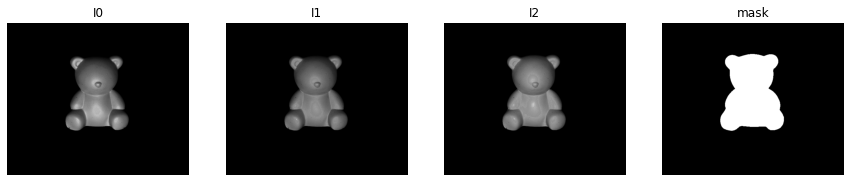

In [5]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/CS188cv/homework 4/pmsData/' ## specify
obj_name =  'bear' ## specify 
## specify the arguments data_dir, obj_name
## obj_name : in the folder ./pmsData, the images of different objects are stored as {obj_name}PNG
## data_dir: path for the pmsData folder, which is provided with the pset files on ccle
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name)

(ii) Write code in the box below to compute the mean and standard deviations for the lighting vectors stored in $L$ obtained from part (i)

In [6]:
## Write code and paste it in overleaf
print(L.shape)
print(np.linalg.norm(L,axis=1).shape)
L_mean = np.mean(np.linalg.norm(L,axis=1))## Complete the expression for mean
L_std = np.std(np.linalg.norm(L,axis=1))## Complete the expression for standard deviation
print("L_mean : {}, L_std : {}".format(L_mean, L_std))

(96, 3)
(96,)
L_mean : 1.0000032447074088, L_std : 2.7981917880143313e-05


(iii) Write the dimensions of $L$ and $I_m$. Note that $I_m$ is not the same as $I$. 

In [7]:
## Write code to print dimensions of L and I_m 
dim_L = L.shape## complete code for shape of L 
I_m = I.reshape(96,I.shape[1]*I.shape[2])## complete code to obtain I_m from I
dim_Im = I_m.shape## complete code for shape of I_m
print("Shape of L: ", dim_L)
print("Shape of dim_Im: ", dim_Im)

Shape of L:  (96, 3)
Shape of dim_Im:  (96, 313344)


### 4.2 - Implementing Photometric Stereo

In this part you will write the code to obtain the surface normals $\hat{N}$ from $L$ and $I_m$

(i) Obtain $\hat{G}$ from $L$ and $I_m$ by completing the code in the block below 

In [25]:
"""
Before obtaining G_hat, you will first compute a vectorized version of G_hat
(denoted by G_hat_vec) of size 3xn 
"""
H, W = I.shape[1], I.shape[2]
L_inv = np.linalg.pinv(L)## complete code to compute the function of L obtained on solving problem 1.3
G_hat_vec = L_inv @ I_m## complete code , using I_m and L_inv
G_hat = G_hat_vec.T## complete code to convert G_hat_vec to the dimensions of G_hat

print('H ',H,'\n','W ',W,sep='')
print('L shape',L.shape)
print('L_inv shape',L_inv.shape)
print('G_hat_vec shape',G_hat_vec.shape)
print('G_hat shape',G_hat.shape)

H 512
W 612
L shape (96, 3)
L_inv shape (3, 96)
G_hat_vec shape (3, 313344)
G_hat shape (313344, 3)


(ii) Write code to obtain $\hat{\rho}$ from the computed G_hat_vec in the previous block

In [44]:
rho_hat = np.linalg.norm(G_hat,axis=1)## Write code to compute rho_hat (n x 1) using G_hat_vec
print('rho_hat shape',rho_hat.shape)

rho_hat shape (313344,)


(iii) Write code to obtain $\hat{N}$.

In [43]:
N_hat_vec = G_hat_vec / rho_hat### complete code to obtain N_hat_vec
N_hat_vec[np.isnan(N_hat_vec)] = 0
N_hat = N_hat_vec.reshape(3, H, W)
print('N_hat_vec shape',N_hat_vec.shape)
print('N_hat shape',N_hat.shape)

N_hat_vec shape (3, 313344)
N_hat shape (3, 512, 612)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [55]:
### Complete the function definition using the parts solved above to compute photometric stereo. 
def compute_Nhat(I,L):
    """
    takes in I, L generated from load_input_data function, returns N_hat of shape (3,H,W).
    H,W : I.shape[1], I.shape[2]
    """
    H, W = I.shape[1], I.shape[2]

    dim_L = L.shape                             ## complete code for shape of L 
    I_m = I.reshape(96,H*W)   ## complete code to obtain I_m from I
    dim_Im = I_m.shape                          ## complete code for shape of I_m


    L_inv = np.linalg.pinv(L)                   ## complete code to compute the function of L obtained on solving problem 1.3
    G_hat_vec = L_inv @ I_m                     ## complete code , using I_m and L_inv
    G_hat = G_hat_vec.T                         ## complete code to convert G_hat_vec to the dimensions of G_hat

    rho_hat = np.linalg.norm(G_hat,axis=1)      ## Write code to compute rho_hat (n x 1) using G_hat_vec

    N_hat_vec = G_hat_vec / rho_hat             ## complete code to obtain N_hat_vec
    N_hat_vec[np.isnan(N_hat_vec)] = 0
    N_hat = N_hat_vec.reshape(3, H, W)

    return N_hat

(iv) Display (a) The obtained reconstruction (b) Ground Truth (c) Error map. Use the helper functions and the code in the block below appropriately

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

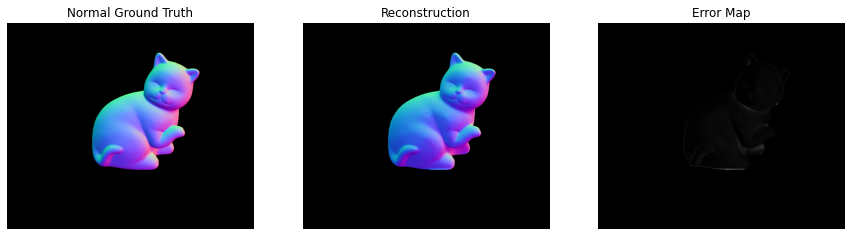

In [57]:
## loading ground truth surface normal image: 
obj_name = 'cat'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images

(v) Use the code in part 4 to generate images for other objects 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

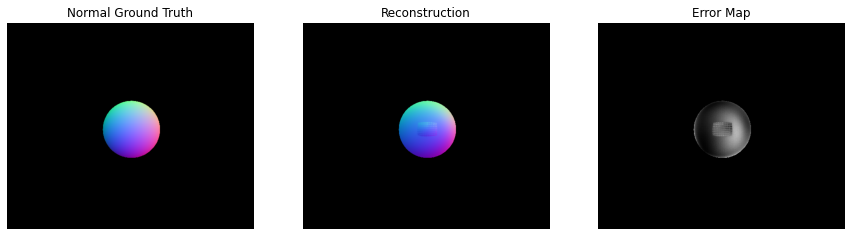

In [66]:
## loading ground truth surface normal image: 
obj_name = 'ball'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

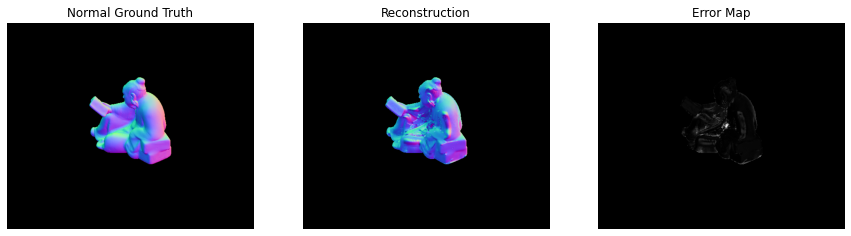

In [59]:
## loading ground truth surface normal image: 
obj_name = 'reading'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

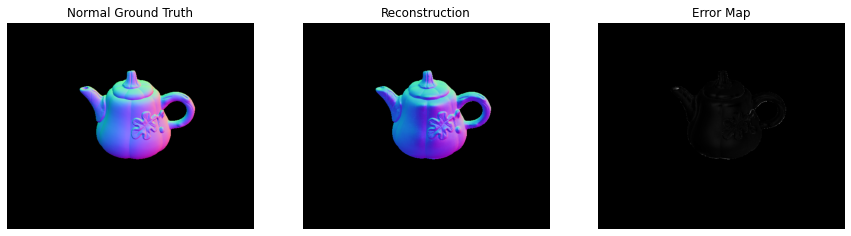

In [64]:
## loading ground truth surface normal image: 
obj_name = 'pot2'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

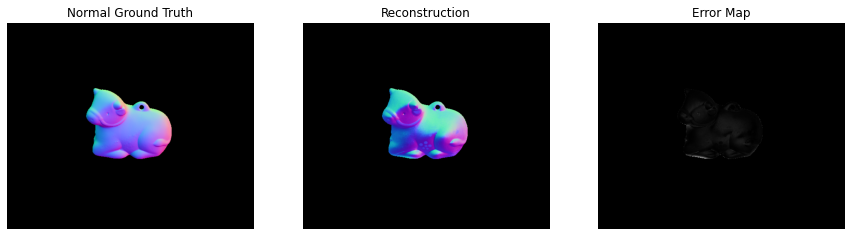

In [62]:
## loading ground truth surface normal image: 
obj_name = 'cow'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

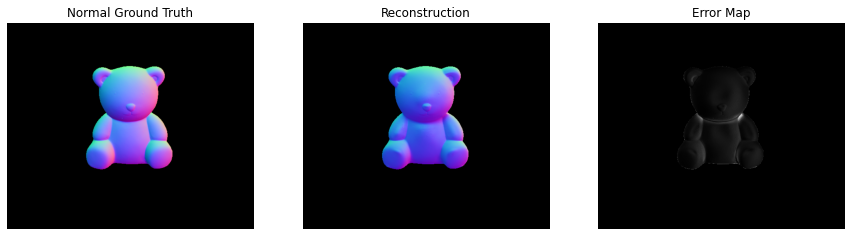

In [67]:
## loading ground truth surface normal image: 
obj_name = 'bear'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

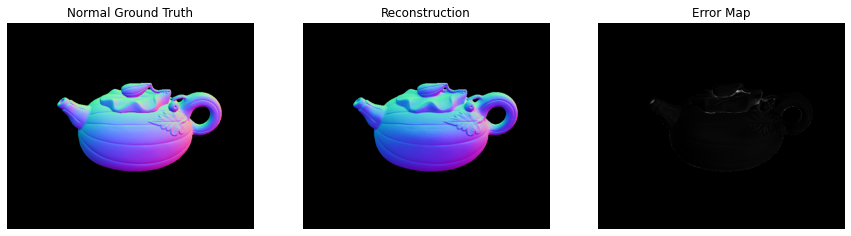

In [68]:
## loading ground truth surface normal image: 
obj_name = 'pot1'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

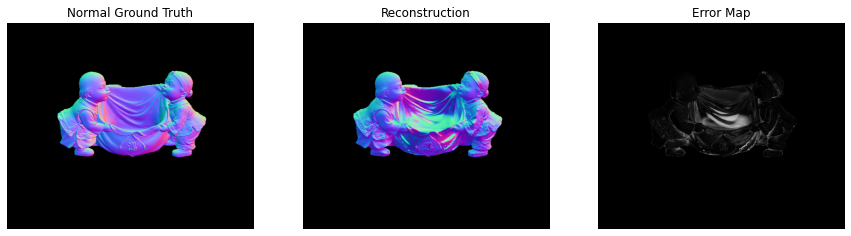

In [69]:
## loading ground truth surface normal image: 
obj_name = 'harvest'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

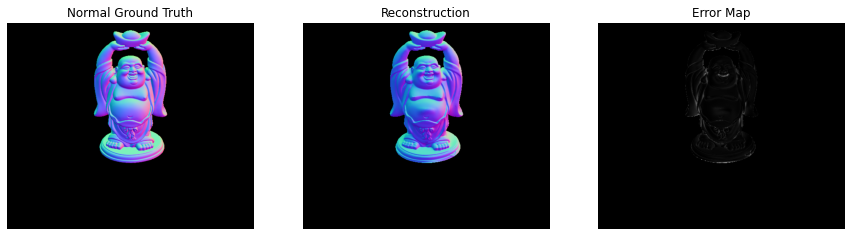

In [71]:
## loading ground truth surface normal image: 
obj_name = 'buddha'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Text(0.5, 1.0, 'Error Map')

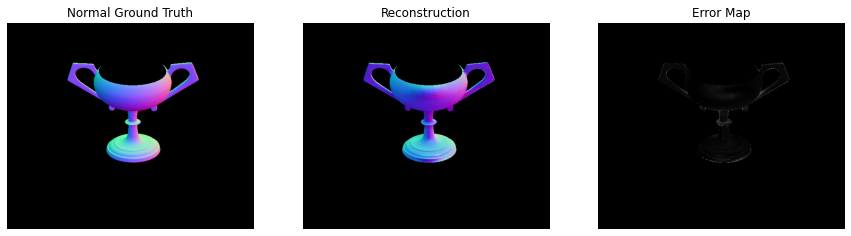

In [72]:
## loading ground truth surface normal image: 
obj_name = 'goblet'
I, L, mask = load_object_data(data_dir = data_dir, obj_name= obj_name, disp = False) # you can redefine data_dir or obj_name here
N_gt = cv2.imread(os.path.join(data_dir, obj_name+ 'PNG', 'Normal_gt.png'))[:,:,::-1]

## Converting N_hat to a displayable image format: 
N_hat = compute_Nhat(I,L)
N_hat_disp = convert_Nhat_img(N_hat, mask)
                  
## Computing Error map between N_hat and N_gt
error_img = get_error_map(N_gt, N_hat_disp, mask)                  

fig, axs = plt.subplots(1, 3, figsize=(15,15))
for i in range(3):
    axs[i].axis('off')
axs[0].imshow(N_gt, cmap='gray')
axs[0].set_title('Normal Ground Truth')
axs[1].imshow(N_hat_disp, cmap='gray')
axs[1].set_title('Reconstruction')
axs[2].imshow(error_img, cmap='gray')
axs[2].set_title('Error Map')

## Figure out how to save the images